In [162]:
####Duration time separation model####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
from scipy import sparse
from scipy.stats import norm
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize

#np.random.seed(98537)

In [163]:
####データの生成####
##データの設定
s = 2
hh = 10000

In [164]:
##応答変数の生成
#セグメント割当の生成
pi = np.array([0.6])
z = np.random.binomial(1, pi, hh)
index_z1 = np.array(np.where(z==1)[0], dtype="int")
index_z2 = np.array(np.where(z==0)[0], dtype="int")
hh1 = index_z1.shape[0]
hh2 = index_z2.shape[0]

#パラメータの生成
Sigma = np.array([1.25])
mu = np.array([3.0])
theta = np.array([0.5])

In [165]:
#応答変数の生成
y = np.repeat(0.0, hh)
y[index_z1] = np.random.normal(mu, Sigma, hh1)
y[index_z2] = np.random.exponential(theta, hh2)
y[y < 0] = 0.0

(array([1909., 1042.,  680.,  447.,  471.,  451.,  521.,  545.,  670.,
         662.,  587.,  536.,  452.,  318.,  280.,  170.,  117.,   63.,
          36.,   21.,   15.,    3.,    2.,    0.,    2.]),
 array([0.        , 0.32019016, 0.64038033, 0.96057049, 1.28076066,
        1.60095082, 1.92114098, 2.24133115, 2.56152131, 2.88171148,
        3.20190164, 3.52209181, 3.84228197, 4.16247213, 4.4826623 ,
        4.80285246, 5.12304263, 5.44323279, 5.76342295, 6.08361312,
        6.40380328, 6.72399345, 7.04418361, 7.36437378, 7.68456394,
        8.0047541 ]),
 <a list of 25 Patch objects>)

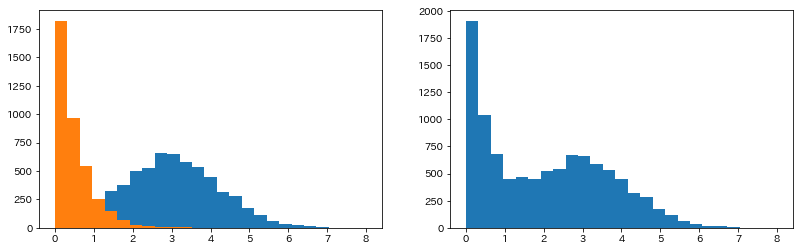

In [166]:
#応答変数の可視化
fig = plt.figure(figsize=(13.5, 4.0))
ax1 = fig.add_subplot(1, 2, 1); ax2 = fig.add_subplot(1, 2, 2)
ax1.hist(y[index_z1], bins=25, range=[0.0, np.max(y)])
ax1.hist(y[index_z2], bins=25, range=[0.0, np.max(y)])
ax2.hist(y, bins=25, range=[0.0, np.max(y)])

In [167]:
####EMアルゴリズムでパラメータを推定####
##観測データの尤度と潜在変数zを計算する関数
def ollz(mu, Sigma, theta, pi, y):
    #モデルごとの尤度を定義
    Lho1 = scipy.stats.norm.pdf(y, mu, Sigma)
    Lho2 = scipy.stats.expon.pdf(y, scale=1/theta)

    #観測データの対数尤度
    Lho = np.hstack((pi*Lho1[:, np.newaxis], (1-pi)*Lho2[:, np.newaxis]))
    LLobz = np.sum(np.log(np.sum(Lho, axis=1)))

    #潜在変数zの定義
    z = Lho / np.sum(Lho, axis=1)[:, np.newaxis]
    return LLobz, z

In [168]:
##EMアルゴリズムの設定
iters = 0
rp = 200   #最大繰り返し数
LL = -1000000000   #対数尤度の初期値
dl = 100   #EMアルゴリズムの対数尤度の差の初期値
tol = 0.1
maxit = 20   #準ニュートン法のステップ数

In [169]:
##EMアルゴリズムの初期値
#混合率と潜在変数の初期値
pi = np.array([1/s])
zpt = np.repeat(pi, hh)

#パラメータの初期値
Sigma = np.random.uniform(1.0, 2.0, 1)
mu = np.random.uniform(1.5, 3.0, 1)
theta = np.random.uniform(0.25, 0.5, 1)

In [170]:
#観測データの対数尤度と潜在変数
oll = ollz(mu, Sigma, theta, pi, y)
zpt = oll[1]
LL1 = oll[0]

In [171]:
##EMアルゴリズムでパラメータを推定
while abs(dl) >= tol:
    
    #Mステップで完全データモデルの最尤推定
    m = np.sum(zpt, axis=0)
    u = zpt * y[:, np.newaxis]
    mu = np.array([np.sum(u[:, 0]) / np.sum(m[0])])
    Sigma = np.sqrt(np.sum(np.power(zpt[:, 0]*(y - mu), 2)) / m[0])
    theta = np.mean(u[:, 1])

    #混合率を更新
    pi = m[0] / hh

    #Eステップで観測データの対数尤度と潜在変数zを更新
    oll = ollz(mu, Sigma, theta, pi, y)
    zpt = oll[1]
    LL = oll[0]

    #EMアルゴリズムのパラメータを更新
    iters = iters + 1
    dl = LL - LL1
    LL1 = LL
    print(LL)

-18181.143060619215
-16890.847490500964
-16712.585953618403
-16720.60961874586
-16763.805300568543
-16783.53057201472
-16777.476286450255
-16757.26595940681
-16732.47809249753
-16708.563324086055
-16687.95506374296
-16671.323804269334
-16658.459956484247
-16648.799169383055
-16641.698920756193
-16636.566015577944
-16632.903460065438
-16630.317578575814
-16628.507764090693
-16627.25036037295
-16626.382166718766
-16625.78588406971
-16625.378219031627
-16625.10060726473
-16624.9122078886
-16624.784735109406
-16624.698712492594
